**Problem: Stochastic Budget-Constrained Price Optimisation**

Each product's demand is modelled as an exponentially decaying function of its price:

$D_i(p_i) = d_i \cdot \exp(-\alpha_i p_i)$

where:
$( D_i(p_i) )$ is the demand for product $( i )$\
$( d_i )$ is the base demand for product $( i )$\
$( \alpha_i )$ is the price sensitivity for product $( i )$\
$( p_i )$ is the price of product $( i )$\

**Objective:**
$\min_{p} \left( -\sum_{i=1}^{n} p_i \cdot D_i(p_i) \right)$

**Subject to customer budget constraints:**

$\sum_{i=1}^{n} \left( p_i \cdot \frac{D_i(p_i)}{\sum_j D_j(p_j)} \cdot d_i \right) \leq B_k, \quad \forall k \in \{1, 2, \dots, m\}$

where:
$( B_k )$ is the budget of customer $( k )$\
$( \frac{D_i(p_i)}{\sum_j D_j(p_j)} \cdot d_i )$ is the expected portion of product ( i ) purchased by customer $( k )$

**Price Bounds:**

$0.01 \leq p_i \leq 10.0$


In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from kan import KAN
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.optimize import minimize

In [70]:
#shared
numProducts = 5
numCustomers = 100
epochs = 1000

torch.manual_seed(42)
np.random.seed(42)

customerBudgets = np.random.uniform(10, 50, numCustomers)
priceSensitivities = np.random.uniform(0.1, 1.0, numProducts)
baseDemands = np.random.uniform(50, 200, numProducts)

def demand(p):
    return torch.tensor(baseDemands, dtype=torch.float32, requires_grad=True) * torch.exp(
        -torch.tensor(priceSensitivities, dtype=torch.float32, requires_grad=True) * p
    )

def revenue(p):
    return torch.sum(p * demand(p))

def constraintViolation(p):
    totalSpending = torch.sum(p * demand(p))
    maxBudget = np.sum(customerBudgets)
    budgetPenalty = torch.relu(totalSpending - maxBudget)
    lowerBoundPenalty = torch.relu(0.01 - p).sum()
    upperBoundPenalty = torch.relu(p - 10.0).sum()
    
    return budgetPenalty + lowerBoundPenalty + upperBoundPenalty



In [98]:
def demand_np(p):
    return baseDemands * np.exp(-priceSensitivities * p)

def revenue_np(p):
    return np.sum(p * demand_np(p))

def constraintViolation_np(p):
    totalSpending = np.sum(p * demand_np(p))
    maxBudget = np.sum(customerBudgets)
    return maxBudget - totalSpending

bounds = [(0.01, 10.0)] * numProducts

constraint = {
    'type': 'ineq',
    'fun': constraintViolation_np 
}

startTimeAnalytical = time.time()
result = minimize(
    fun=lambda p: -revenue_np(p),
    x0=np.ones(numProducts) * 5.0,
    bounds=bounds,
    constraints=[constraint],
    method='SLSQP',
    options={'maxiter': 1000}
)
endTimeAnalytical = time.time()

timeAnalytical = endTimeAnalytical - startTimeAnalytical
optPricesAnalytical = result.x
revAnalytical = revenue_np(optPricesAnalytical)

print(f"Optimal Prices:         {optPricesAnalytical}")
print(f"Final Revenue:          {revAnalytical:.2f}")
print(f"Computation Time:       {timeAnalytical:.2f} seconds")


Optimal Prices:         [7.79519454 1.4863725  2.61152681 1.79296718 1.09068319]
Final Revenue:          548.85
Computation Time:       0.03 seconds


c:\Users\A\VSCodeRepos\Investigating-mathematical-optimisation-using-KANs\.venv\Lib\site-packages\scipy\optimize\_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [134]:
xPrices = np.random.uniform(1, 20, size=(10000, numProducts))
yRevenues = np.array([revenue(torch.tensor(p, dtype=torch.float32)).item() for p in xPrices])
xTensor = torch.tensor(xPrices, dtype=torch.float32)
yTensor = torch.tensor(yRevenues, dtype=torch.float32).view(-1, 1)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(numProducts, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

mlpEpochs = 5000
mlpNRuns = 5

mlpAllFinalPrices = []
mlpAllFinalRevenues = []
mlpAllTrainingTimes = []
mlpAllLosses = []

for run in range(mlpNRuns):
    mlpModel = MLP()
    mlpOptimiser = optim.Adam(mlpModel.parameters(), lr=0.001)
    mlpLosses = []

    startTimeMlp = time.time()
    for epoch in range(mlpEpochs):
        mlpModel.train()
        mlpOptimiser.zero_grad()
        preds = mlpModel(xTensor)
        loss = nn.MSELoss()(preds, yTensor)
        loss.backward()
        mlpOptimiser.step()
        mlpLosses.append(loss.item())
    endTimeMlp = time.time()
    mlpTime = endTimeMlp - startTimeMlp

    mlpModel.eval()
    with torch.no_grad():
        grid = torch.tensor(np.random.uniform(1, 10, size=(10000, numProducts)), dtype=torch.float32)
        preds = mlpModel(grid).squeeze()

        feasibleIndices = []
        feasibleRevenues = []
        for prediction in range(grid.shape[0]):
            prices = grid[prediction]
            spend = torch.sum(prices * demand(prices))
            if spend <= np.sum(customerBudgets):
                feasibleIndices.append(prediction)
                feasibleRevenues.append(preds[prediction].item())

        feasibleIndices = np.array(feasibleIndices)
        feasibleRevenues = np.array(feasibleRevenues)

        if len(feasibleIndices) > 0:
            bestPrediction = feasibleIndices[np.argmax(feasibleRevenues)]
            mlpFinalPrices = grid[bestPrediction]
            mlpFinalRevenue = revenue(mlpFinalPrices).item()
        else:
            mlpFinalPrices = None
            mlpFinalRevenue = None

    mlpAllFinalPrices.append(mlpFinalPrices)
    mlpAllFinalRevenues.append(mlpFinalRevenue)
    mlpAllTrainingTimes.append(mlpTime)
    mlpAllLosses.append(mlpLosses)

    print(f"Run {run+1}: Final Revenue = {mlpFinalRevenue:.2f}, Training Time = {mlpTime:.2f} seconds")


Run 1: Final Revenue = 506.63, Training Time = 59.01 seconds
Run 2: Final Revenue = 483.47, Training Time = 78.48 seconds
Run 3: Final Revenue = 536.57, Training Time = 70.82 seconds
Run 4: Final Revenue = 500.59, Training Time = 68.74 seconds
Run 5: Final Revenue = 516.52, Training Time = 74.83 seconds


In [129]:
kanEpochs = 1000
kanNRuns = 5

kanAllFinalPrices = []
kanAllFinalRevenues = []
kanAllTrainingTimes = []
kanAllLosses = []

for run in range(kanNRuns):
    kanModel = KAN(width=[numProducts, 6, 6, 1], grid=10, k=3, seed=run)
    kanOptimiser = optim.Adam(kanModel.parameters(), lr=0.01)
    kanLosses = []

    startTimeKan = time.time()
    for epoch in range(kanEpochs):
        kanModel.train()
        kanOptimiser.zero_grad()
        preds = kanModel(xTensor)
        loss = nn.MSELoss()(preds.squeeze(), yTensor.squeeze())
        loss.backward()
        kanOptimiser.step()
        kanLosses.append(loss.item())
    endTimeKan = time.time()
    kanTime = endTimeKan - startTimeKan

    kanModel.eval()
    with torch.no_grad():
        grid = torch.tensor(np.random.uniform(1, 10, size=(10000, numProducts)), dtype=torch.float32)
        preds = kanModel(grid).squeeze()

        feasibleIndices = []
        feasibleRevenues = []
        for prediction in range(grid.shape[0]):
            prices = grid[prediction]
            spend = torch.sum(prices * demand(prices))
            if spend <= np.sum(customerBudgets):
                feasibleIndices.append(prediction)
                feasibleRevenues.append(preds[prediction].item())

        feasibleIndices = np.array(feasibleIndices)
        feasibleRevenues = np.array(feasibleRevenues)
        
        bestPrediction = feasibleIndices[np.argmax(feasibleRevenues)]
        kanFinalPrices = grid[bestPrediction]
        kanFinalRevenue = revenue(kanFinalPrices).item()

    kanAllFinalPrices.append(kanFinalPrices)
    kanAllFinalRevenues.append(kanFinalRevenue)
    kanAllTrainingTimes.append(kanTime)
    kanAllLosses.append(kanLosses)

    print(f"Run {run+1}: Final Revenue = {kanFinalRevenue:.2f}, Training Time = {kanTime:.2f} seconds")


checkpoint directory created: ./model
saving model version 0.0
Run 1: Final Revenue = 515.25, Training Time = 358.15 seconds
checkpoint directory created: ./model
saving model version 0.0
Run 2: Final Revenue = 530.81, Training Time = 353.80 seconds
checkpoint directory created: ./model
saving model version 0.0
Run 3: Final Revenue = 527.04, Training Time = 363.16 seconds
checkpoint directory created: ./model
saving model version 0.0
Run 4: Final Revenue = 517.49, Training Time = 407.60 seconds
checkpoint directory created: ./model
saving model version 0.0
Run 5: Final Revenue = 536.42, Training Time = 374.09 seconds


In [135]:
comparisonData = {
    "Metric": [
        "Mean Final Revenue",
        "Std Final Revenue",
        "Mean Computation Time (s)",
        "Std Computation Time (s)",
        "Mean Training Loss",
        "Std Training Loss",
        "Example Optimal Prices"
    ],
    "MLP": [
        np.mean(mlpAllFinalRevenues),
        np.std(mlpAllFinalRevenues),
        np.mean(mlpAllTrainingTimes),
        np.std(mlpAllTrainingTimes),
        np.mean([np.mean(runLosses) for runLosses in mlpAllLosses]),
        np.std([np.mean(runLosses) for runLosses in mlpAllLosses]),
        mlpAllFinalPrices[0].tolist()
    ],
    "KAN": [
        np.mean(kanAllFinalRevenues),
        np.std(kanAllFinalRevenues),
        np.mean(kanAllTrainingTimes),
        np.std(kanAllTrainingTimes),
        np.mean([np.mean(runLosses) for runLosses in kanAllLosses]),
        np.std([np.mean(runLosses) for runLosses in kanAllLosses]),
        kanAllFinalPrices[0].tolist()
    ]
}

comparisonDF = pd.DataFrame(comparisonData)

display(comparisonDF)


,Metric,MLP,KAN
0,Mean Final Revenue,508.757324,525.401794
1,Std Final Revenue,17.577276,7.989663
2,Mean Computation Time (s),70.376559,371.361592
3,Std Computation Time (s),6.59581,19.342401
4,Mean Training Loss,2877.080853,5819.957858
5,Std Training Loss,121.190358,662.542752
6,Example Optimal Prices,"[7.297652721405029, 1.264718770980835, 1.10752...","[9.05564022064209, 1.3208684921264648, 2.97593..."


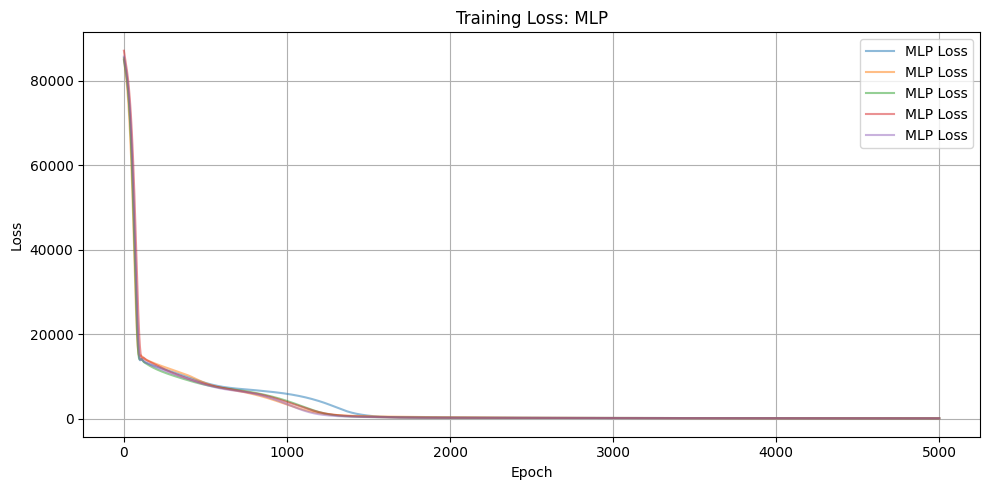

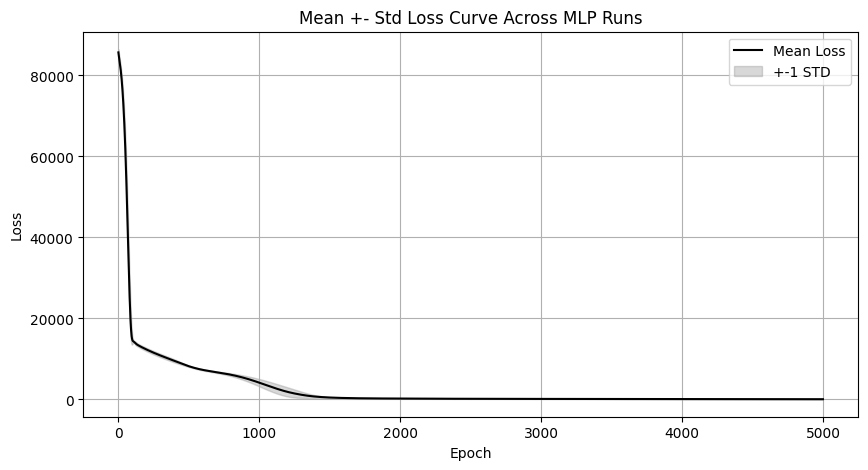

In [137]:
#mlp loss
plt.figure(figsize=(10, 5))
for runLosses in mlpAllLosses:
    plt.plot(runLosses, label="MLP Loss", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss: MLP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mlpLossArray = np.array(mlpAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)

#mean +- std loss graph
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="Mean Loss", color='black')
plt.fill_between(range(mlpEpochs), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

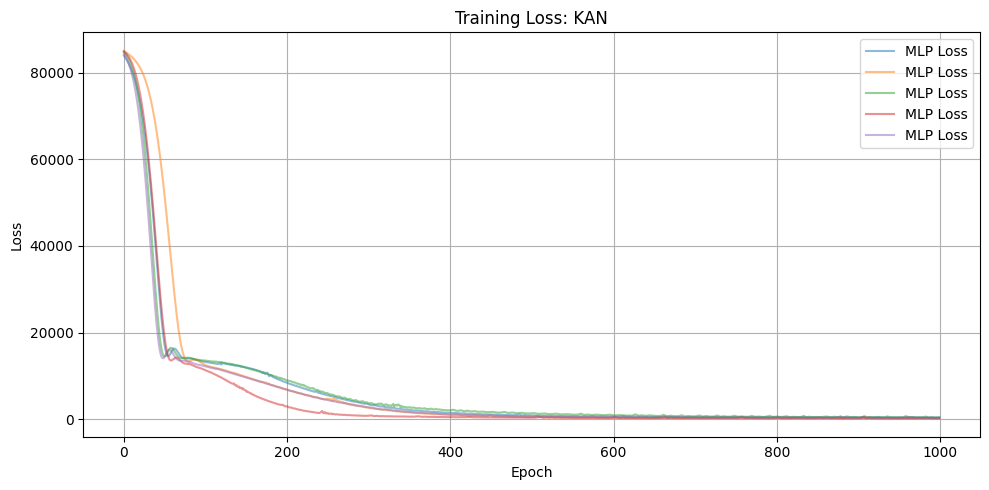

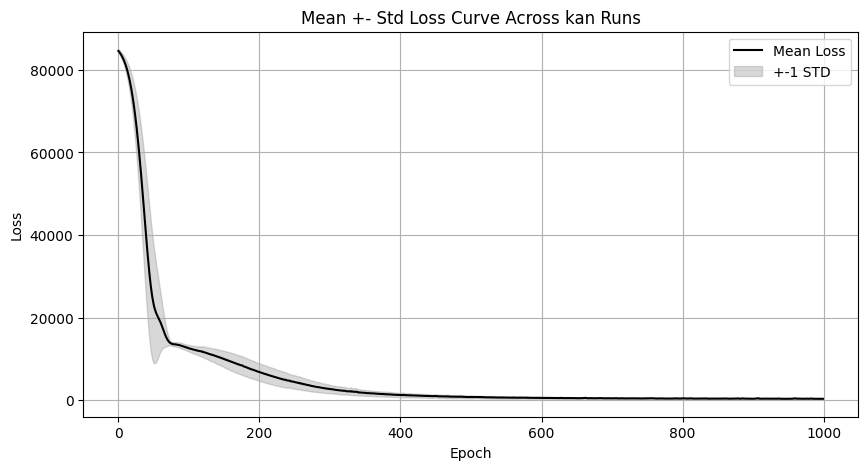

In [138]:
plt.figure(figsize=(10, 5))
for runLosses in kanAllLosses:
    plt.plot(runLosses, label="MLP Loss", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss: KAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

#mean +- std loss graph
plt.figure(figsize=(10, 5))
plt.plot(kanMeanLoss, label="Mean Loss", color='black')
plt.fill_between(range(kanEpochs), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across kan Runs")
plt.grid(True)
plt.legend()
plt.show()

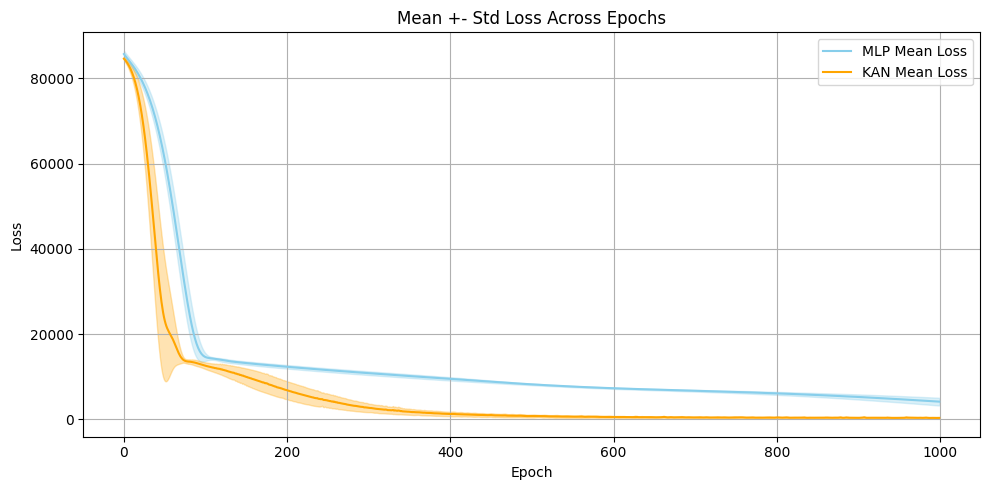

In [139]:
#loss comparison
mlpLossArray = np.array(mlpAllLosses)
kanLossArray = np.array(kanAllLosses)

mlpMeanLoss = np.mean(mlpLossArray, axis=0)[:1000]
mlpStdLoss = np.std(mlpLossArray, axis=0)[:1000]

kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="MLP Mean Loss", color='skyblue')
plt.fill_between(range(len(mlpMeanLoss)),
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(kanMeanLoss, label="KAN Mean Loss", color='orange')
plt.fill_between(range(len(kanMeanLoss)),
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Across Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

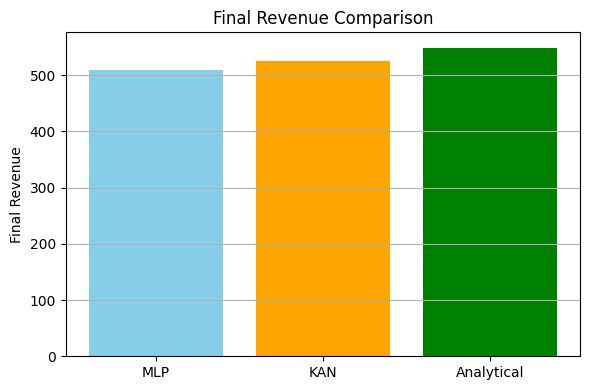

In [143]:
plt.figure(figsize=(6, 4))
plt.bar(["MLP", "KAN", "Analytical"], [np.mean(mlpAllFinalRevenues),np.mean(kanAllFinalRevenues), revAnalytical], color=["skyblue", "orange", "green"])
plt.ylabel("Final Revenue")
plt.title("Final Revenue Comparison")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


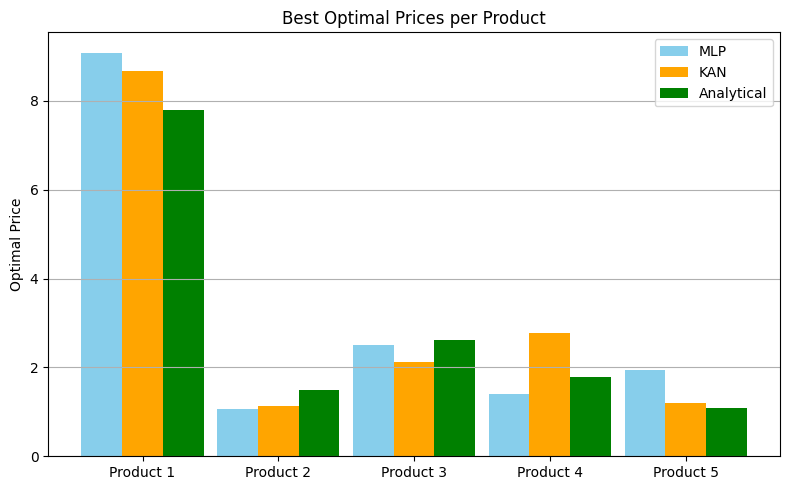

In [152]:
x = np.arange(numProducts)
width = 0.3
mlpBestFinalPrices = mlpAllFinalPrices[np.argmax(mlpAllFinalRevenues)]
kanBestFinalPrices = kanAllFinalPrices[np.argmax(kanAllFinalRevenues)]
plt.figure(figsize=(8, 5))
plt.bar(x - width, mlpBestFinalPrices, width, label="MLP", color="skyblue")
plt.bar(x, kanBestFinalPrices, width, label="KAN", color="orange")
plt.bar(x + width, optPricesAnalytical, width, label="Analytical", color="green")

plt.xticks(x, [f"Product {i+1}" for i in x])
plt.ylabel("Optimal Price")
plt.title("Best Optimal Prices per Product")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [154]:
import pickle

mlpResults = {
    "finalRevenues": mlpAllFinalRevenues,
    "finalPrices": mlpAllFinalPrices,
    "times": mlpAllTrainingTimes,
    "losses": mlpAllLosses
}

kanResults = {
    "finalRevenues": kanAllFinalRevenues,
    "finalPrices": kanAllFinalPrices,
    "times": kanAllTrainingTimes,
    "losses": kanAllLosses
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)